In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

In [221]:
def calcular_precision(y, pred):
    return(np.sum((pred == 1) & (y == 1))/np.sum(pred == 1))

In [222]:
def calcular_recall(y, pred):
    return(np.sum((pred == 1) & (y == 1))/np.sum(y == 1))

In [223]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({"threshold":thresholds_2, 
                         "precision":precision, 
                         "recall":recall})
    df_1 = df_1.assign(f1_score = 2*(df_1.precision*df_1.recall)/(df_1.precision+df_1.recall))
    
    df_2 = pd.DataFrame({"tpr":tpr, "fpr":fpr, "threshold":thresholds})
    df_2 = df_2.assign(tnr = 1-df_2["fpr"])
    df_2 = df_2.assign(fnr = 1-df_2["tpr"])
    
    df = df_1.merge(df_2, on = "threshold")
    
    return(df)

In [224]:
def calcular_metricas(y, predicted_scores, threshold = 0.5):
    pred = 1*(predicted_scores >= threshold)
    
    tpr = np.sum((y == 1) & (pred == 1))/np.sum(y == 1)
    fpr = np.sum((y == 0) & (pred == 1))/np.sum(y == 0)
    tnr = np.sum((y == 0) & (pred == 0))/np.sum(y == 0)
    fnr = np.sum((y == 1) & (pred == 0))/np.sum(y == 1)
    
    precision = calcular_precision(y, pred)
    recall = calcular_recall(y, pred)
    
    res = pd.DataFrame({
        "score":[threshold], 
        "precision":[precision], 
        "recall":[recall], 
        "tpr":[tpr], 
        "fpr":[fpr], 
        "tnr":[tnr], 
        "fnr":[fnr]
    })
    
    return(res)

In [225]:
datos = pd.read_csv("../data/datos_modelo.csv")

In [226]:
features = [
    
    "Industry", 
    #"Vertical", 
    #"VerticalCategory", 
    #"ATUName", 
    #"AM", 
    "SumPCCount", 
    "SumServerCount", 
    #"SumSmartPhoneCount", 
    #"SumTabletCount", 
    "SumEmployeeCount", 
    
    "ACR_FY21-Q1", 
    "ACR_FY21-Q2", 
    "ACR_FY21-Q3", 
    "ACR_FY21-Q4", 

    "FY21-Q1", 
    "FY21-Q2", 
    "FY21-Q3", 
    "FY21-Q4", 
    
    "HasRevenue"    
]

In [227]:
datos = datos[features]

In [228]:
datos.columns.values[-5:-1] = ["quarter_lag_4", "quarter_lag_3", "quarter_lag_2", "quarter_lag_1"]
datos.columns.values[-9:-5] = ["acr_quarter_lag_4", "acr_quarter_lag_3", "acr_quarter_lag_2", "acr_quarter_lag_1"]

In [229]:
np.random.seed(123)
n = datos.shape[1-1]
train_size = 0.70
indices_ent = np.random.choice(np.arange(0, datos.shape[1-1]), int(np.floor(train_size*n)), replace = False)

In [230]:
n_jobs = 4

In [231]:
X = datos.drop(columns = ["HasRevenue"])
y = datos.HasRevenue

variables_explicativas = X.columns.values

temp_ent, temp_val, y_ent, y_val = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

temp_ent = pd.DataFrame(temp_ent, columns = variables_explicativas).reset_index(drop = True)
temp_val = pd.DataFrame(temp_val, columns = variables_explicativas).reset_index(drop = True)

num_cols = temp_ent._get_numeric_data().columns
cat_cols = [col for col in temp_ent.columns if col not in num_cols]

preprocessor = ColumnTransformer(
    [("onehot", OneHotEncoder(sparse = False, handle_unknown = "ignore"), cat_cols)], 
    remainder = "drop", 
    n_jobs = n_jobs
)

x_ent_prep = preprocessor.fit_transform(temp_ent)

encoded_cat_cols = preprocessor.named_transformers_["onehot"].get_feature_names(cat_cols)
x_ent_prep = pd.DataFrame(x_ent_prep, columns = encoded_cat_cols)

x_ent = pd.DataFrame(pd.concat([temp_ent[num_cols], x_ent_prep], axis = 1))
x_ent[encoded_cat_cols] = x_ent[encoded_cat_cols].apply(lambda x: x.replace(np.nan, 0))

mu = x_ent[num_cols].mean()

x_ent[num_cols] = x_ent[num_cols].fillna(mu)

print("ent: ")
print(x_ent.shape)
print(y_ent.shape)

x_val_prep = preprocessor.transform(temp_val)

x_val_prep = pd.DataFrame(x_val_prep, columns = encoded_cat_cols)

x_val = pd.DataFrame(pd.concat([temp_val[num_cols], x_val_prep], axis = 1))
x_val[encoded_cat_cols] = x_val[encoded_cat_cols].apply(lambda x: x.replace(np.nan, 0))

x_val[num_cols] = x_val[num_cols].fillna(mu)

print("val: ")
print(x_val.shape)
print(y_val.shape)

rf = RandomForestClassifier(
    n_estimators = 5000, 
    random_state = 42, 
    n_jobs = n_jobs, 
    max_depth = 30, 
    verbose = 0
)

rf.fit(x_ent, y_ent)

predicted_scores = rf.predict_proba(x_val)[:, 2-1]
pred_val = rf.predict(x_val)
accuracy_rf = accuracy_score(y_val, pred_val)
precision_rf = calcular_precision(y_val, pred_val)
recall_rf = calcular_recall(y_val, pred_val)

fpr, tpr, thresholds = roc_curve(y_val, predicted_scores, pos_label = 1)

precision, recall, thresholds_2 = precision_recall_curve(y_val, predicted_scores, pos_label = 1)
thresholds_2 = np.append(thresholds_2, 1)

metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)

ent: 
(4322, 50)
(4322,)
val: 
(2130, 50)
(2130,)


In [197]:
X = datos.drop(columns = ["HasRevenue"])
y = datos.HasRevenue

variables_explicativas = X.columns.values

temp_ent, temp_val, y_ent, y_val = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

temp_ent = pd.DataFrame(temp_ent, columns = variables_explicativas).reset_index(drop = True)
temp_val = pd.DataFrame(temp_val, columns = variables_explicativas).reset_index(drop = True)

num_cols = temp_ent._get_numeric_data().columns

x_ent = temp_ent

mu = x_ent[num_cols].mean()

x_ent[num_cols] = x_ent[num_cols].fillna(mu)

print("ent: ")
print(x_ent.shape)
print(y_ent.shape)

x_val = temp_val

x_val[num_cols] = x_val[num_cols].fillna(mu)

print("val: ")
print(x_val.shape)
print(y_val.shape)

rf = RandomForestClassifier(
    n_estimators = 1000, 
    random_state = 42, 
    n_jobs = n_jobs, 
    max_depth = 15, 
    verbose = 0
)

rf.fit(x_ent, y_ent)

predicted_scores = rf.predict_proba(x_val)[:, 2-1]
pred_val = rf.predict(x_val)
accuracy_rf = accuracy_score(y_val, pred_val)
precision_rf = calcular_precision(y_val, pred_val)
recall_rf = calcular_recall(y_val, pred_val)

fpr, tpr, thresholds = roc_curve(y_val, predicted_scores, pos_label = 1)

precision, recall, thresholds_2 = precision_recall_curve(y_val, predicted_scores, pos_label = 1)
thresholds_2 = np.append(thresholds_2, 1)

metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)

ent: 
(4322, 12)
(4322,)
val: 
(2130, 12)
(2130,)


ValueError: could not convert string to float: 'Transport & Logistics'

In [232]:
pd.DataFrame({"accuracy":[accuracy_rf], "precision_rf":[precision_rf], "recall_rf":[recall_rf]})

,accuracy,precision_rf,recall_rf
0,0.935211,0.874172,0.830189


In [233]:
conf = confusion_matrix(y_val, pred_val)
conf = pd.DataFrame(conf, index = ["real_0", "real_1"], columns = ["pred_0", "pred_1"])
conf

,pred_0,pred_1
real_0,1596,57
real_1,81,396


In [234]:
calcular_metricas(y_val, predicted_scores, 0.5)

,score,precision,recall,tpr,fpr,tnr,fnr
0,0.5,0.874172,0.830189,0.830189,0.034483,0.965517,0.169811


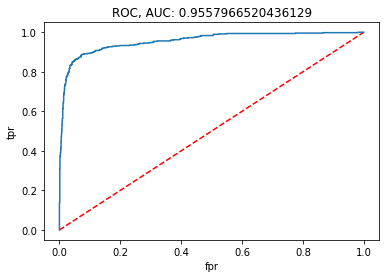

In [235]:
plt.clf()
plt.plot([0, 1], [0, 1], "k--", c = "red")
plt.plot(fpr, tpr)
plt.title("ROC, AUC: {}".format(roc_auc_score(y_val, predicted_scores)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

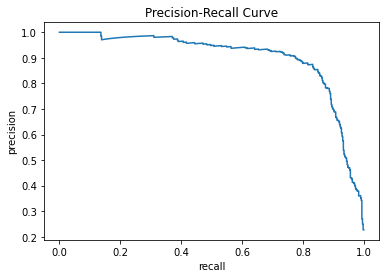

In [236]:
plt.clf()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("recall")
plt.ylabel("precision")
#plt.ylim((0, 1))
plt.show()

In [237]:
feature_importances = pd.DataFrame({"feature":x_ent.columns.values, 
                                   "importance":rf.feature_importances_
                                   }) \
                        .sort_values(by = ["importance"], ascending = False).reset_index(drop = True)
feature_importances

,feature,importance
0,quarter_lag_4,0.528689
1,acr_quarter_lag_1,0.068683
2,acr_quarter_lag_2,0.055099
3,quarter_lag_1,0.054613
4,quarter_lag_2,0.050224
5,acr_quarter_lag_3,0.048297
6,quarter_lag_3,0.047928
7,acr_quarter_lag_4,0.042864
8,SumEmployeeCount,0.019077
9,SumPCCount,0.016355


In [238]:
datos["HasRevenue"].value_counts()

0    5003
1    1449
Name: HasRevenue, dtype: int64

In [239]:
datos.shape

(6452, 13)

In [250]:
datos_total = pd.read_csv("../data/datos_modelo.csv")

In [251]:
features = [
    
    "Industry", 
    #"Vertical", 
    #"VerticalCategory", 
    #"ATUName", 
    #"AM", 
    "SumPCCount", 
    "SumServerCount", 
    #"SumSmartPhoneCount", 
    #"SumTabletCount", 
    "SumEmployeeCount", 
    
    "ACR_FY21-Q2", 
    "ACR_FY21-Q3", 
    "ACR_FY21-Q4", 
    "ACR_FY22-Q1", 

    "FY21-Q2", 
    "FY21-Q3", 
    "FY21-Q4", 
    "FY22-Q1", 
    
    "HasRevenue"    
]

In [252]:
datos_total = datos_total[features]

In [253]:
datos_total.columns.values[-5:-1] = ["quarter_lag_4", "quarter_lag_3", "quarter_lag_2", "quarter_lag_1"]
datos_total.columns.values[-9:-5] = ["acr_quarter_lag_4", "acr_quarter_lag_3", "acr_quarter_lag_2", "acr_quarter_lag_1"]

In [254]:
X = datos_total.drop(columns = ["HasRevenue"])

x_total_prep = preprocessor.transform(X)

x_total_prep = pd.DataFrame(x_total_prep, columns = encoded_cat_cols)

x_total = pd.DataFrame(pd.concat([X[num_cols], x_total_prep], axis = 1))
x_total[encoded_cat_cols] = x_total[encoded_cat_cols].apply(lambda x: x.replace(np.nan, 0))

x_total[num_cols] = x_total[num_cols].fillna(mu)

predicted_scores_total = rf.predict_proba(x_total)[:, 2-1]

prediction = rf.predict(x_total)

In [257]:
temp = pd.read_csv("../data/datos_modelo.csv")

res = pd.DataFrame({"tpid":temp.TPID,  
                    "score":predicted_scores_total, 
                    "prediction":prediction})

In [259]:
res.to_csv("../data/Accounts with score.csv", index = False)